# Bike Sharing Demand Prediction

The following notebook is a typical example for a data science workflow that does not 
yet use experiment tracking. It will serve as a starting point for our exercises. Your 
task will be to add experiment tracking to the notebook. 

Let's first go over the steps of the workflow:

- Loading Data 
- Splitting the dataset 
- Exploratory Data Analysis (EDA)
- Define numerical and categorical features
- Train-test split
- Build a reusable training pipeline
- Train a model using linear regression
- Evaluate model performance

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
RANDOM_STATE = 42

## Step 1: Loading the Data Set into a Pandas DataFrame

- Load the dataset into a Pandas DataFrame
- Inspect (part of) the dataset using the .head() method

In [3]:
bike_sharing_data = pd.read_csv("./data/hour.csv")
bike_sharing_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Step 2: Exploratory Data Analysis (EDA)

### Step 2.1: Plot the distribution of the target variable

- Plot the distribution of the target variable ('cnt') using sns.displot().
- Plot absolute counts or the probability density

Text(-8.055555555555555, 0.5, 'Probability density')

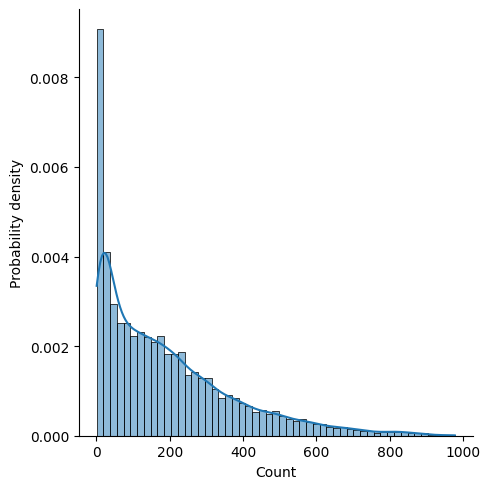

In [4]:
sns.displot(bike_sharing_data["cnt"], kde=True, stat="density")
plt.xlabel("Count")
plt.ylabel("Probability density")

### Step 2.2: Investigate feature-target relationships

- Feel free to try out different features 

<Axes: xlabel='season', ylabel='cnt'>

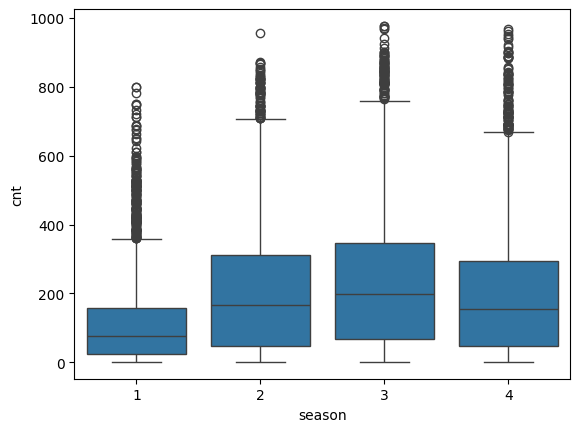

In [5]:
sns.boxplot(data=bike_sharing_data, x="season", y="cnt")

## Step 3: Define Numerical and Categorical Features

In [6]:
NUMERICAL_FEATURES = ["temp", "hum", "windspeed"]
CATEGORICAL_FEATURES = ["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

TARGET = "cnt"

In [7]:
features_target = bike_sharing_data[FEATURES + [TARGET]]
features_target.head()

,temp,hum,windspeed,season,mnth,hr,holiday,weekday,workingday,weathersit,cnt
0,0.24,0.81,0.0,1,1,0,0,6,0,1,16
1,0.22,0.80,0.0,1,1,1,0,6,0,1,40
2,0.22,0.80,0.0,1,1,2,0,6,0,1,32
3,0.24,0.75,0.0,1,1,3,0,6,0,1,13
4,0.24,0.75,0.0,1,1,4,0,6,0,1,1


## Step 4: Train-test Split


- Split the dataset into a training and testing dataset
- Split both the train and test sets into "input" and "output" (i.e, "train_input", "train_output", etc.)
    - The "input" will contain all the features and will serve as the input to the model training and the predictions.
    - The "output" will be used as target in the model training and as ground truth in the evaluations.

In [8]:
train_data, test_data = train_test_split(features_target, random_state=RANDOM_STATE)

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

## Step 5: Building a Reusable Training Pipeline

Define a function that builds a reusable training pipeline. The functions
takes an estimator and returns a Scikit-Learn pipeline containing the preprocessing
and model training steps.

In [9]:
numerical_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ("numerical", numerical_transformer, NUMERICAL_FEATURES),
    ("categorical", categorical_transformer, CATEGORICAL_FEATURES),
])

def build_pipeline(estimator):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("estimator", estimator),
    ])

## Step 6: Evaluate Model Performance

In [10]:
def root_mean_squared_log_error(y_true, y_pred):
    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    squared_log_diff = log_diff ** 2
    mean_squared_log_diff = np.mean(squared_log_diff)
    return np.sqrt(mean_squared_log_diff)

In [11]:
def calculate_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmsle = root_mean_squared_log_error(y_true, y_pred)

    print(f"RMSE: {rmse:.5f}")
    print(f"R² score: {r2:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"RMSLE: {rmsle:0.5f}")

## Step 7: Train a Model using Linear Regression

Create a linear regression pipeline and fit the pipeline to the training data

In [12]:
pipeline = build_pipeline(LinearRegression())
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
calculate_metrics(y_test, predictions)

RMSE: 109.25290
R² score: 0.62883
MAE: 78.48131
RMSLE: 0.83593


/tmp/ipykernel_7411/3231794781.py:2: RuntimeWarning: invalid value encountered in log1p
  log_diff = np.log1p(y_pred) - np.log1p(y_true)


## Step 8: Handle Skewed Training Data with Log Transform

- Recreate the linear regression pipeline and fit it to the log transformed data
- Create predictions using the new model
- Inverse the log transformation on the predictions
- Evaluate the model performance using the evaluate() function and compare the results

In [13]:
# y_train_log_transformed = np.log1p(y_train)

In [14]:
# pipeline = build_pipeline(LinearRegression())
# pipeline.fit(X_train, y_train_log_transformed)

# predictions = pipeline.predict(X_test)
# predictions = np.expm1(predictions)

# calculate_metrics(y_test, predictions)

## Step 9: Different Model - Random Forest Regressor

- Create a random forest regressor pipeline.
- Fit the pipeline, create predictions, and evaluate the model.
- Compare the model performance between the two different model types.

In [15]:
# pipeline = build_pipeline(RandomForestRegressor(random_state=RANDOM_STATE))
# pipeline.fit(X_train, y_train)

# predictions = pipeline.predict(X_test)

# calculate_metrics(y_test, predictions)

In [16]:
# pipeline = build_pipeline(RandomForestRegressor(random_state=RANDOM_STATE))
# pipeline.fit(X_train, y_train_log_transformed)

# predictions = pipeline.predict(X_test)
# predictions = np.expm1(predictions)

# calculate_metrics(y_test, predictions)